In [1]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
from data import fr
%matplotlib inline

In [2]:
fr_path = 'pretrained_models/DeepFreq/frequency_representation_module.pth'
fc_path = 'pretrained_models/DeepFreq/frequency_counting_module.pth'
data_dir = 'test_dataset'

In [3]:
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr')
fc_module, _, _, _, _ = util.load(fc_path, 'fc')
fr_module.cpu()
fr_module.eval()
fc_module.cpu()
fc_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [4]:
#load data
f = np.load(os.path.join(data_dir, 'f.npy'))
signal_0dB = np.load(os.path.join(data_dir, '0.0dB.npy'))
signal_10dB = np.load(os.path.join(data_dir, '10.0dB.npy'))
signal_50dB = np.load(os.path.join(data_dir, '50.0dB.npy'))
nfreq = nfreq = np.sum(f >= -0.5, axis=1)

### Frequency estimation

In [5]:
idx = 8

In [6]:
with torch.no_grad():
    fr_0dB = fr_module(torch.tensor(signal_0dB[idx][None]))
    nestimate_0dB = fc_module(fr_0dB).numpy().round()
    fr_10dB = fr_module(torch.tensor(signal_10dB[idx][None]))
    nestimate_10dB = fc_module(fr_10dB).numpy().round()
    fr_50dB = fr_module(torch.tensor(signal_50dB[idx][None]))
    nestimate_50dB = fc_module(fr_50dB).numpy().round()
fr_0dB = fr_0dB.numpy()    
fr_0dB = fr_10dB.numpy()    
fr_50dB = fr_50dB.numpy()

Number of frequencies:

In [7]:
nfreq[idx]

9

Estimated number of frequencies 0dB/10dB/50dB:

In [8]:
nestimate_0dB[0, 0], nestimate_10dB[0, 0], nestimate_50dB[0, 0]

(8.0, 8.0, 9.0)

Compute frequency estimates:

In [9]:
f_estimate_0dB = fr.find_freq(fr_0dB, nestimate_0dB, xgrid)
f_estimate_10dB = fr.find_freq(fr_10dB, nestimate_10dB, xgrid)
f_estimate_50dB = fr.find_freq(fr_50dB, nestimate_50dB, xgrid)

### 50dB

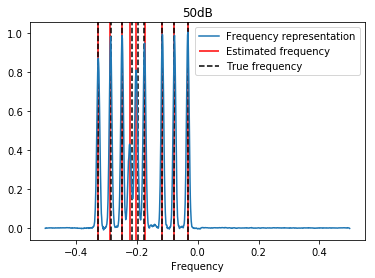

In [10]:
fig, ax = plt.subplots()
ax.plot(xgrid, fr_50dB[0], label='Frequency representation')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
f_model = f_estimate_50dB[f_estimate_50dB > -1]
ax.vlines(f_model, ymin=ylim[0], ymax=ylim[1], color='r', label='Estimated frequency')
ax.vlines(ff, linestyle='--', ymin=ylim[0], ymax=ylim[1], color='k', label='True frequency')
ax.set_ylim(ylim)
ax.set_xlabel('Frequency')
ax.set_title('50dB')
ax.legend()

### 10dB

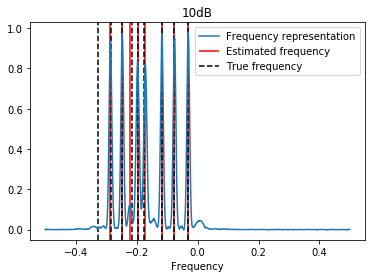

In [11]:
fig, ax = plt.subplots()
ax.plot(xgrid, fr_10dB[0], label='Frequency representation')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
f_model = f_estimate_10dB[f_estimate_10dB > -1]
ax.vlines(f_model, ymin=ylim[0], ymax=ylim[1], color='r', label='Estimated frequency')
ax.vlines(ff, linestyle='--', ymin=ylim[0], ymax=ylim[1], color='k', label='True frequency')
ax.set_ylim(ylim)
ax.set_xlabel('Frequency')
ax.set_title('10dB')
ax.legend()

### 0dB

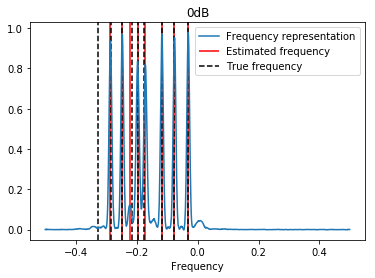

In [12]:
fig, ax = plt.subplots()
ax.plot(xgrid, fr_0dB[0], label='Frequency representation')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
f_model = f_estimate_0dB[f_estimate_0dB > -1]
ax.vlines(f_model, ymin=ylim[0], ymax=ylim[1], color='r', label='Estimated frequency')
ax.vlines(ff, linestyle='--', ymin=ylim[0], ymax=ylim[1], color='k', label='True frequency')
ax.set_ylim(ylim)
ax.set_xlabel('Frequency')
ax.set_title('0dB')
ax.legend()

### Impact of the noise

In [13]:
idx = 13
with torch.no_grad():
    fr_0dB = fr_module(torch.tensor(signal_0dB[idx][None])).numpy()[0]
    fr_10dB = fr_module(torch.tensor(signal_10dB[idx][None])).numpy()[0]
    fr_50dB = fr_module(torch.tensor(signal_50dB[idx][None])).numpy()[0]

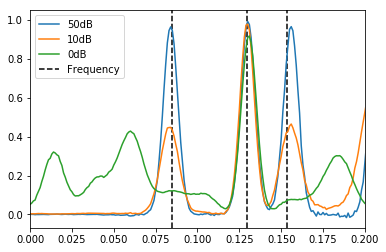

In [14]:
fig, ax = plt.subplots()
ax.plot(xgrid, fr_50dB, label='50dB')
ax.plot(xgrid, fr_10dB, label='10dB')
ax.plot(xgrid, fr_0dB, label='0dB')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
ax.set_ylim(ylim)
ax.set_xlim(0., 0.2)
ax.legend()

### Comparison with other methods

In [15]:
idx = 13

In [16]:
signal_50dB_c = signal_50dB[:, 0]+ 1j * signal_50dB[:, 1]
signal_10dB_c = signal_10dB[:, 0]+ 1j * signal_10dB[:, 1]

In [17]:
with torch.no_grad():
    fr_10dB = fr_module(torch.tensor(signal_10dB[idx][None]))[0]
    fr_50dB = fr_module(torch.tensor(signal_50dB[idx][None]))[0]
music_fr_10dB = fr.music(signal_10dB_c[idx][None], xgrid, nfreq[idx][None])[0]
periodogram_10dB = fr.periodogram(signal_10dB_c[idx][None], xgrid)[0]
music_fr_50dB = fr.music(signal_50dB_c[idx][None], xgrid, nfreq[idx][None])[0]
periodogram_50dB = fr.periodogram(signal_50dB_c[idx][None], xgrid)[0]

In [18]:
cbl = True
if cbl:
    import sys
    sys.path.append('/usr/local/lib/python3.5/dist-packages/')
    import matlab.engine
    eng = matlab.engine.start_matlab()
    eng.cd(r'cblasso')

In [19]:
if cbl:
    res_10dB = eng.polynomial(matlab.double(list(signal_10dB_c[idx]), is_complex=True))
    res_10dB = np.asarray(res_10dB)
    cbl_10dB = np.roll(res_10dB[:, 0], fr_module.fr_size//2)
    res_50dB = eng.polynomial(matlab.double(list(signal_50dB_c[idx]), is_complex=True))
    res_50dB = np.asarray(res_50dB)
    cbl_50dB = np.roll(res_50dB[:, 0], fr_module.fr_size//2)
    grid = np.roll(res_50dB[:, 1], fr_module.fr_size//2)
    grid[grid >= 0.5] -= 1

# 50dB

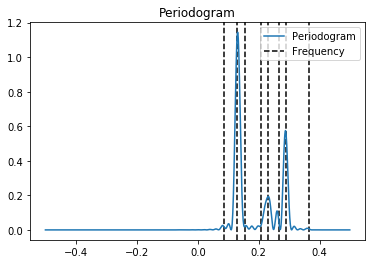

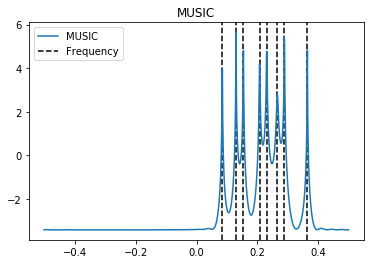

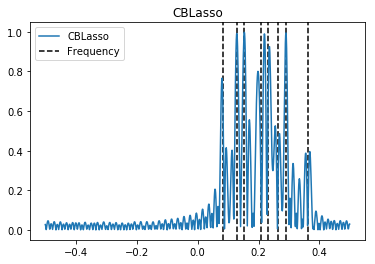

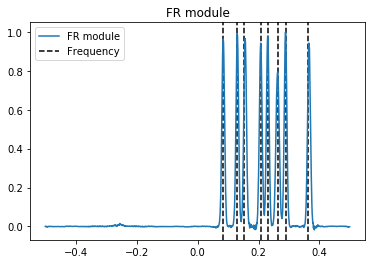

In [20]:
fig, ax = plt.subplots()
ax.plot(xgrid, periodogram_50dB, label='Periodogram')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
ax.set_ylim(ylim)
ax.set_title('Periodogram')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(xgrid, music_fr_50dB, label='MUSIC')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
ax.set_ylim(ylim)
ax.set_title('MUSIC')
ax.legend()
plt.show()

if cbl:
    fig, ax = plt.subplots()
    ax.plot(grid, np.abs(cbl_50dB), label='CBLasso')
    ylim = ax.get_ylim()
    ff = f[idx][f[idx] > -1]
    ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
    ax.set_ylim(ylim)
    ax.set_title('CBLasso')
    ax.legend()
    plt.show()

fig, ax = plt.subplots()
ax.plot(xgrid, fr_50dB, label='FR module')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
ax.set_ylim(ylim)
ax.set_title('FR module')
ax.legend()
plt.show()

# 10dB

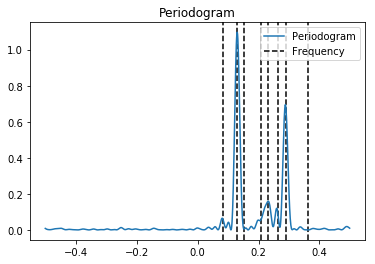

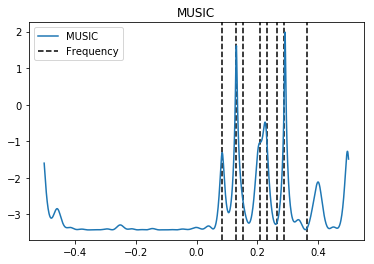

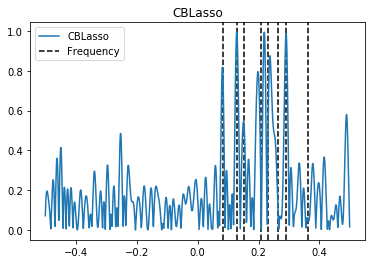

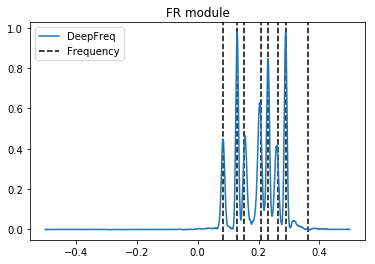

In [21]:
fig, ax = plt.subplots()
ax.plot(xgrid, periodogram_10dB, label='Periodogram')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
ax.set_ylim(ylim)
ax.set_title('Periodogram')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(xgrid, music_fr_10dB, label='MUSIC')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
ax.set_ylim(ylim)
ax.set_title('MUSIC')
ax.legend()
plt.show()

if cbl:
    fig, ax = plt.subplots()
    ax.plot(grid, np.abs(cbl_10dB), label='CBLasso')
    ylim = ax.get_ylim()
    ff = f[idx][f[idx] > -1]
    ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
    ax.set_ylim(ylim)
    ax.set_title('CBLasso')
    ax.legend()
    plt.show()

fig, ax = plt.subplots()
ax.plot(xgrid, fr_10dB, label='DeepFreq')
ylim = ax.get_ylim()
ff = f[idx][f[idx] > -1]
ax.vlines(ff, ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', label='Frequency')
ax.set_ylim(ylim)
ax.set_title('FR module')
ax.legend()
plt.show()